In [35]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
import requests
import json
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error

from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/covid19countryinfo.csv
./input/states-daily.csv
./input/covid19-deepscore.csv
./input/population_data.csv
./input/full-list-total-tests-for-covid-19.csv
./input/country_codes.csv
./input/enriched_covid_19_week_2.csv
./input/covid19-global-forecasting-week-3/test.csv
./input/covid19-global-forecasting-week-3/submission.csv
./input/covid19-global-forecasting-week-3/train.csv
./input/korea/SeoulFloating.csv
./input/korea/TimeAge.csv
./input/korea/SearchTrend.csv
./input/korea/TimeProvince.csv
./input/korea/Weather.csv
./input/korea/PatientRoute.csv
./input/korea/PatientInfo.csv
./input/korea/Region.csv
./input/korea/TimeGender.csv
./input/korea/Case.csv
./input/korea/Time.csv
./input/covid19-global-forecasting-week-2/test.csv
./input/covid19-global-forecasting-week-2/submission.csv
./input/covid19-global-forecasting-week-2/train.csv
./input/covidAPI/ESP.json
./input/covidAPI/ICL.json
./input/covidAPI/CHN.json
./input/covidAPI/FRA.json
./input/covidAPI/THA.json
./input/covidAPI/DNK

# 2. Preparing the training data

In [36]:
def code_to_entity(code):
    dic = {"KOR": "South Korea", "ITA": "Italy", "FRA": "France", "DEU": "Germany", "ISL": "Iceland", "DNK": "Denmark", "THA": "Thailand", "TWN": "Taiwan"}
    return dic[code]

In [37]:
# Get API data (confirmed, deaths, recovered)
# filter by country codes
country_codes = ["KOR", "ITA", "FRA", "DEU", "ISL", "DNK", "THA", "TWN"]

for country in country_codes:
    response = requests.get('https://covidapi.info/api/v1/country/{}'.format(country))
    try:
        data = response.json()
    except:
        print("{} not found".format(country))
    with open("./input/covidAPI/{}.json".format(country), "w") as f:
        json.dump(data["result"], f, indent=4)

In [38]:
original_df = pd.read_csv("./input/full-list-total-tests-for-covid-19.csv")

# unify date format
original_df["Date"] = [datetime.strftime(datetime.strptime(date, '%b %d, %Y'), '%Y-%m-%d') for date in original_df["Date"]]
original_df = original_df.rename(columns={"Total tests": "test"})
original_df.head()

,Entity,Code,Date,test
0,Argentina,ARG,2020-04-08,13330
1,Argentina,ARG,2020-04-09,14850
2,Argentina,ARG,2020-04-10,16379
3,Argentina,ARG,2020-04-11,18027
4,Argentina,ARG,2020-04-13,19758


In [39]:
original_df = original_df.query("Code in {}".format(country_codes))
original_df.reset_index(inplace=True, drop=True)
original_df.head()

,Entity,Code,Date,test
0,Denmark,DNK,2020-03-20,10730
1,Denmark,DNK,2020-03-21,11657
2,Denmark,DNK,2020-03-23,12938
3,Denmark,DNK,2020-03-24,13988
4,Denmark,DNK,2020-03-25,14959


In [40]:
# Merge Dataframe
import json

new_df = original_df
for code in country_codes:
    with open("./input/covidAPI/{}.json".format(code), "r") as f:
        j = json.load(f)
    # for each date
    for key in j.keys():
        # for each in (confirmed, deaths, recovered)
        for k in j[key].keys():
            if ((new_df['Code'] == code) & (new_df['Date'] == key)).any():
                new_df.loc[(new_df["Code"] == code) & (new_df["Date"] == key), k] = j[key][k]
            else:
                s = pd.Series([code_to_entity(code), code, key, j[key][k]], index=["Entity", "Code", "Date", k])
                new_df = new_df.append(s,ignore_index=True)
new_df = new_df.sort_values(['Code', 'Date'])
new_df.reset_index(inplace=True, drop=True)
print(new_df.head())

Entity Code        Date  test  confirmed  deaths  recovered
0  Germany  DEU  2020-01-22   NaN        0.0     0.0        0.0
1  Germany  DEU  2020-01-23   NaN        0.0     0.0        0.0
2  Germany  DEU  2020-01-24   NaN        0.0     0.0        0.0
3  Germany  DEU  2020-01-25   NaN        0.0     0.0        0.0
4  Germany  DEU  2020-01-26   NaN        0.0     0.0        0.0


In [41]:
# Interpolate
new_df["test"].where(new_df["confirmed"] != 0.0, 0.0, inplace=True)
# add test values to unique countries
for code in ["THA", "TWN"]:
    first_confirmed = new_df.loc[(new_df["Code"] == code) & (new_df["Date"] == "2020-01-22"), "confirmed"].values[0]
    new_df.loc[(new_df["Code"] == code) & (new_df["Date"] == "2020-01-22"), "test"] = new_df.loc[(new_df["Code"] == "KOR") & (new_df["confirmed"] == first_confirmed), "test"].values[0]

for code in country_codes:
    tmp_df = new_df[new_df["Code"] == code]
    tmp_df.interpolate(inplace=True)
    new_df[new_df["Code"]==code] = tmp_df
print(new_df.head())

Entity Code        Date  test  confirmed  deaths  recovered
0  Germany  DEU  2020-01-22   0.0        0.0     0.0        0.0
1  Germany  DEU  2020-01-23   0.0        0.0     0.0        0.0
2  Germany  DEU  2020-01-24   0.0        0.0     0.0        0.0
3  Germany  DEU  2020-01-25   0.0        0.0     0.0        0.0
4  Germany  DEU  2020-01-26   0.0        0.0     0.0        0.0


In [42]:
# Add rates
# new_df["infectious_rate"] = (new_df["test"] - new_df["negative"]) / new_df["test"]
new_df["infectious_rate"] = new_df["confirmed"] / new_df["test"]
new_df["removed_rate"] = (new_df["deaths"] + new_df["recovered"]) / new_df["test"]
new_df["susceptible_rate"] = 1.0 - (new_df["infectious_rate"] + new_df["removed_rate"])
new_df["infectious_rate_change"] = 0.0
new_df["removed_rate_change"] = 0.0
new_df["susceptible_rate_change"] = 0.0

# Drop nulls
new_df.dropna(how='any', inplace=True)
print(new_df.head())

Entity Code        Date          test  confirmed  deaths  recovered  \
5  Germany  DEU  2020-01-27   2969.428571        1.0     0.0        0.0   
6  Germany  DEU  2020-01-28   5938.857143        4.0     0.0        0.0   
7  Germany  DEU  2020-01-29   8908.285714        4.0     0.0        0.0   
8  Germany  DEU  2020-01-30  11877.714286        4.0     0.0        0.0   
9  Germany  DEU  2020-01-31  14847.142857        5.0     0.0        0.0   

   infectious_rate  removed_rate  susceptible_rate  infectious_rate_change  \
5         0.000337           0.0          0.999663                     0.0   
6         0.000674           0.0          0.999326                     0.0   
7         0.000449           0.0          0.999551                     0.0   
8         0.000337           0.0          0.999663                     0.0   
9         0.000337           0.0          0.999663                     0.0   

   removed_rate_change  susceptible_rate_change  
5                  0.0            

In [141]:
# Normalizing Rates
def mu_sigma_justify(Y, floor_n=1, ceil_n=1.5, mu=None, sigma=None):
    """μとσを用いた補正関数。

    Args:
        floor_n (float):
        ceil_n (float):
        mu (Optional[float]):
        sigma (Optional[float]):

    """
    mu = mu or Y.mean()
    sigma = sigma or Y.std()
    Y = Y.copy()
    Y_ = Y.copy()
    Y[abs(Y_ - mu) < floor_n * sigma] = mu  # μ±σ ⇒ μ
    Y[Y_ > mu + ceil_n * sigma] = mu + ceil_n * sigma  # μ＋3σ より大きい ⇒ μ＋3σ
    Y[Y_ < mu - ceil_n * sigma] = mu - ceil_n * sigma  # μー3σ より小さい ⇒ μー3σ
    return Y

# Calculate Change Rate
for code in country_codes:
    tmp_df = new_df[new_df["Code"] == code]
    tmp_df["infectious_rate_change"] = tmp_df["infectious_rate"].pct_change()
    tmp_df["infectious_rate_change"] = tmp_df["infectious_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    tmp_df["infectious_rate_change"] = mu_sigma_justify(tmp_df["infectious_rate_change"].values)
    tmp_df["removed_rate_change"] = tmp_df["removed_rate"].pct_change()
    tmp_df["removed_rate_change"] = tmp_df["removed_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    tmp_df["removed_rate_change"] = mu_sigma_justify(tmp_df["removed_rate_change"].values)
    tmp_df["susceptible_rate_change"] = tmp_df["susceptible_rate_change"].pct_change()
    tmp_df["susceptible_rate_change"] = tmp_df["susceptible_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    tmp_df["susceptible_rate_change"] = mu_sigma_justify(tmp_df["susceptible_rate_change"].values)
    new_df[new_df["Code"]==code] = tmp_df
    
# Save
new_df.to_csv("./input/covid19-deepscore.csv")
print(new_df)

Entity Code        Date          test  confirmed  deaths  recovered  \
5    Germany  DEU  2020-01-27   2969.428571        1.0     0.0        0.0   
6    Germany  DEU  2020-01-28   5938.857143        4.0     0.0        0.0   
7    Germany  DEU  2020-01-29   8908.285714        4.0     0.0        0.0   
8    Germany  DEU  2020-01-30  11877.714286        4.0     0.0        0.0   
9    Germany  DEU  2020-01-31  14847.142857        5.0     0.0        0.0   
10   Germany  DEU  2020-02-01  17816.571429        8.0     0.0        0.0   
11   Germany  DEU  2020-02-02  20786.000000       10.0     0.0        0.0   
12   Germany  DEU  2020-02-03  23755.428571       12.0     0.0        0.0   
13   Germany  DEU  2020-02-04  26724.857143       12.0     0.0        0.0   
14   Germany  DEU  2020-02-05  29694.285714       12.0     0.0        0.0   
15   Germany  DEU  2020-02-06  32663.714286       12.0     0.0        0.0   
16   Germany  DEU  2020-02-07  35633.142857       13.0     0.0        0.0   
17   

In [44]:
train_df = new_df
train_df.tail()

,Entity,Code,Date,test,confirmed,deaths,recovered,infectious_rate,removed_rate,susceptible_rate,infectious_rate_change,removed_rate_change,susceptible_rate_change
784,Taiwan,TWN,2020-04-24,59840.0,428.0,6.0,264.0,0.007152,0.004512,0.988336,-0.011293,0.028290,0.0
785,Taiwan,TWN,2020-04-25,60459.0,429.0,6.0,275.0,0.007096,0.004648,0.988257,-0.007926,0.030085,0.0
786,Taiwan,TWN,2020-04-26,60956.0,429.0,6.0,281.0,0.007038,0.004708,0.988254,-0.008153,0.013025,0.0
787,Taiwan,TWN,2020-04-27,61684.0,429.0,6.0,290.0,0.006955,0.004799,0.988247,-0.011802,0.019187,0.0
788,Taiwan,TWN,2020-04-28,62368.0,429.0,6.0,307.0,0.006879,0.005019,0.988103,-0.010967,0.045835,0.0


In [45]:
#Just getting rid of the first days to have a multiple of 14
#Makes it easier to generate the sequences
train_country = ["KOR", "TWA", "THA", "ITA", "ISL", "DNK"]
# train_df = train_df.query("Date>'2020-01-22'and Date<='2020-03-25'")
train_df = train_df.query("Code in {}".format(train_country))
days_in_sequence = 14

trend_list = []

with tqdm(total=len(list(train_df.Code.unique()))) as pbar:
    for code in train_df.Code.unique():
        country_df = train_df.query(f"Code=='{code}'")
        # Added a quick hack to double the number of sequences
        # Warning: This will later create a minor leakage from the training set into the validation set.
        for i in range(0,len(country_df),int(days_in_sequence/2)):
            if i+days_in_sequence<=len(country_df):
                expected_cases = float(country_df.iloc[i+days_in_sequence-1].confirmed)
                expected_fatalities = float(country_df.iloc[i+days_in_sequence-1].deaths)

                #prepare rate inputs
                infectious_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].infectious_rate_change]
                removed_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].removed_rate_change]
                susceptible_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].susceptible_rate_change] 

                #prepare outputs
                expected_infectious_rate = float(country_df.iloc[i+days_in_sequence-1].infectious_rate_change)
                expected_removed_rate = float(country_df.iloc[i+days_in_sequence-1].removed_rate_change)

                trend_list.append({ "infectious_rate_trend":infectious_rate_trend,
                                    "removed_rate_trend":removed_rate_trend,
                                    "susceptible_rate_trend":susceptible_rate_trend,
                                    "expected_infectious_rate":expected_infectious_rate,
                                    "expected_removed_rate":expected_removed_rate})
        pbar.update(1)
trend_df = pd.DataFrame(trend_list)

100%|██████████| 5/5 [00:00<00:00, 31.20it/s]


In [46]:
trend_df["temporal_inputs"] = [np.asarray([trends["infectious_rate_trend"], trends["removed_rate_trend"], trends["susceptible_rate_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)
print(len(trend_df))
trend_df.head()

52


,expected_infectious_rate,expected_removed_rate,infectious_rate_trend,removed_rate_trend,susceptible_rate_trend,temporal_inputs
24,-0.030027,-0.010541,"[-0.024993499225843818, -0.01904887745835626, ...","[0.0031195499110812097, -0.004315048218986317,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-0.024993499225843818, -0.01904887745835626,..."
38,-0.010436,-0.003656,"[-0.01078650450796792, -0.005777197658737854, ...","[-0.002494932620735746, 0.01050944053360281, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-0.01078650450796792, -0.005777197658737854,..."
3,-0.034576,4.740437,"[0.047776148582600264, 0.04397515527950335, -0...","[0.33636363636363664, 0.3664596273291927, 0.28...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.047776148582600264, 0.04397515527950335, -..."
17,0.153820,2.298341,"[-0.06666666666666676, -0.06250000000000011, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.869...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-0.06666666666666676, -0.06250000000000011, ..."
15,-0.071429,0.000000,"[0.0, -0.5, -0.33333333333333326, -0.25, -0.19...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, -0.5, -0.33333333333333326, -0.25, -0.1..."


In [47]:
sequence_length = 13
training_percentage = 0.9

temp_dim = 3

In [48]:
training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

In [49]:
X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,temp_dim,sequence_length)),(0,2,1) )).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_infectious_rate"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_removed_rate"]]).astype(np.float32)

In [50]:
X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,temp_dim,sequence_length)),(0,2,1)) ).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_infectious_rate"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_removed_rate"]]).astype(np.float32)

# 3. Model

In [51]:
#temporal input branch
temporal_input_layer = Input(shape=(sequence_length,temp_dim))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2)(temporal_input_layer)

#demographic input branch
# demographic_input_layer = Input(shape=(dem_dim,))
# demographic_dense = layers.Dense(16)(demographic_input_layer)
# demographic_dropout = layers.Dropout(0.2)(demographic_dense)

#cases output branch
rnn_c = layers.LSTM(32)(main_rnn_layer)
# merge_c = layers.Concatenate(axis=-1)([rnn_c,demographic_dropout])
dense_c = layers.Dense(16)(rnn_c)
dropout_c = layers.Dropout(0.3)(dense_c)
output_c = layers.Dense(1)(dropout_c) #activation=layers.LeakyReLU(alpha=0.1)
cases = layers.LeakyReLU(alpha=0.1,name="infectious")(output_c)

#fatality output branch
rnn_f = layers.LSTM(32)(main_rnn_layer)
# merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
dense_f = layers.Dense(16)(rnn_f)
dropout_f = layers.Dropout(0.3)(dense_f)
output_f = layers.Dense(1)(dropout_f)
fatalities = layers.LeakyReLU(alpha=0.1, name="removed")(output_f)


model = Model([temporal_input_layer], [cases,fatalities])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 13, 3)        0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 13, 64)       17408       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 32)           12416       lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 32)           12416       lstm[0][0]                       
__________________________________________________________________________________________________
dense (Den

In [52]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.6), #patience=4  #EarlyStopping(monitor='val_loss', patience=20)
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.mean_squared_logarithmic_error,tf.keras.losses.mean_squared_logarithmic_error], optimizer="adam")

In [53]:
history = model.fit([X_temporal_train], [Y_cases_train, Y_fatalities_train], 
          epochs = 50, 
          batch_size = 16, 
          validation_data=([X_temporal_test],  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)

Train on 46 samples, validate on 6 samples
Epoch 1/50
46/46 [==============================] - 5s 111ms/step - loss: 0.1130 - infectious_loss: 0.0044 - removed_loss: 0.1085 - val_loss: 0.0033 - val_infectious_loss: 0.0028 - val_removed_loss: 4.8361e-04
Epoch 2/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0998 - infectious_loss: 0.0037 - removed_loss: 0.0961 - val_loss: 0.0045 - val_infectious_loss: 0.0035 - val_removed_loss: 0.0010
Epoch 3/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0987 - infectious_loss: 0.0037 - removed_loss: 0.0950 - val_loss: 0.0091 - val_infectious_loss: 0.0042 - val_removed_loss: 0.0049
Epoch 4/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0877 - infectious_loss: 0.0032 - removed_loss: 0.0845 - val_loss: 0.0154 - val_infectious_loss: 0.0039 - val_removed_loss: 0.0115
Epoch 5/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0867 - infectious_loss: 0.0040 - removed_loss: 0.0827 - val_l

# 4. Performance during training

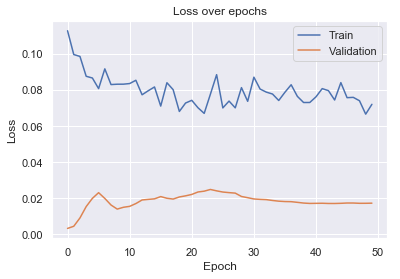

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

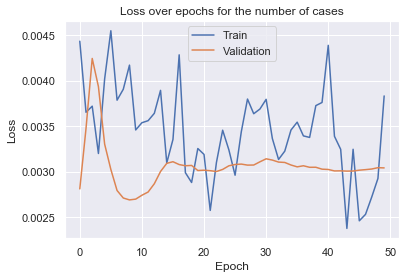

In [55]:
plt.plot(history.history['infectious_loss'])
plt.plot(history.history['val_infectious_loss'])
plt.title('Loss over epochs for the number of cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

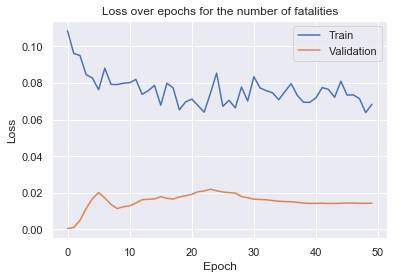

In [56]:
plt.plot(history.history['removed_loss'])
plt.plot(history.history['val_removed_loss'])
plt.title('Loss over epochs for the number of fatalities')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

# 5. Generate predictions using the model

In [57]:
model.load_weights("best_model.h5")
predictions = model.predict([X_temporal_test])

In [58]:
display_limit = 30
for inputs, pred_cases, exp_cases, pred_fatalities, exp_fatalities in zip(X_temporal_test,predictions[0][:display_limit], Y_cases_test[:display_limit], predictions[1][:display_limit], Y_fatalities_test[:display_limit]):
    print("================================================")
    print(inputs)
    print("Expected infectious rate:", exp_cases, " Prediction:", pred_cases[0], "Expected removed rate:", exp_fatalities, " Prediction:", pred_fatalities[0] )

[[-0.01604664  0.09143706  0.        ]
 [-0.03906668 -0.04188212  0.        ]
 [-0.06825207 -0.06989805  0.        ]
 [-0.02457861 -0.04671298  0.        ]
 [-0.00364806 -0.02840294  0.        ]
 [-0.03773015 -0.03051418  0.        ]
 [-0.02708999 -0.0058364   0.        ]
 [-0.03664764 -0.01025503  0.        ]
 [-0.00861406 -0.01355945  0.        ]
 [-0.01674582  0.04073722  0.        ]
 [-0.00578236  0.04509913  0.        ]
 [-0.00538853  0.01965881  0.        ]
 [ 0.00034379  0.07998603  0.        ]]
Expected infectious rate: -0.02085578  Prediction: 0.0048575536 Expected removed rate: 0.03355542  Prediction: -0.0003303273
[[-0.13225058  0.          0.        ]
 [-0.11680328  0.          0.        ]
 [ 1.1821138   0.          0.        ]
 [-0.09580985  0.          0.        ]
 [ 0.08100233  0.          0.        ]
 [-0.17181467  0.          0.        ]
 [-0.08973092  0.          0.        ]
 [ 0.00954132  0.          0.        ]
 [-0.02337199  0.          0.        ]
 [-0.18276261  0

# 6. Apply the model to predict future trends

In [103]:
#Will retrieve the number of cases and fatalities for the past 14
def build_inputs_for_date(code, date, pdf, gdf):
    start_date = date - timedelta(days=13)
    end_date = date - timedelta(days=1)
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    tdf = pdf[(pdf["Code"] == code) & (pdf["Date"] >= str_start_date) & (pdf["Date"] <= str_end_date)]

    #preparing the temporal inputs
    temporal_input_data = np.transpose(np.reshape(np.asarray([tdf["infectious_rate_change"],
                                                 tdf["removed_rate_change"],
                                                 tdf["susceptible_rate_change"]]),
                                     (3,sequence_length)), (1,0) ).astype(np.float32)
    
    return [np.array([temporal_input_data])]

In [128]:
#Take a dataframe in input, will do the predictions and return the dataframe with extra rows
#containing the predictions
def predict_for_region(code, pdf, gdf):
    tdf = pdf[pdf["Code"]==code]
    # begin_prediction = "2020-03-26"
    begin_prediction = tdf.iloc[0]["Date"]
    start_date = datetime.strptime(begin_prediction,"%Y-%m-%d") + timedelta(14)
    print("prediction start date: {}".format(datetime.strftime(start_date, "%Y-%m-%d")))
    # end_prediction = "2020-04-15"
    end_prediction = tdf.iloc[-1]["Date"]
    end_date = datetime.strptime(end_prediction,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range((end_date-start_date).days+1)]
    for date in date_list:
        input_data = build_inputs_for_date(code, date, pdf, gdf)
        result = model.predict(input_data)
        
        #just ensuring that the outputs is
        #higher than the previous counts
        # result[0] = np.round(result[0])
        if result[0]<input_data[0][0][-1][0]:
            result[0]=np.array([[input_data[0][0][-1][0]]])
        
        # result[1] = np.round(result[1])
        if result[1]<input_data[0][0][-1][1]:
            result[1]=np.array([[input_data[0][0][-1][1]]])

        
        # add predicted results
        pdf.loc[(pdf["Code"] == code) & (pdf["Date"] == date.strftime("%Y-%m-%d")), ["infectious_rate_change", "removed_rate_change"]] = [result[0][0][0], result[1][0][0]]
        # pdf = df.append({"Code":code,
        #                 "Date":date.strftime("%Y-%m-%d"), 
        #                 "infectious_rate":result[0][0][0],	
        #                 "removed_rate":result[1][0][0]},
        #                ignore_index=True)
    return pdf

In [129]:
#The functions that are called here need to optimise, sorry about that!
test_country = ["DEU", "FRA"]
pdf = new_df.query("Code in {}".format(test_country)) # prediction data frame
gdf = new_df.query("Code in {}".format(test_country)) # groundtruth data frame
with tqdm(total=len(list(pdf.Code.unique()))) as pbar:
    for code in test_country: #copy_df.Code.unique()
        pdf = predict_for_region(code, pdf, gdf)
        pbar.update(1)
pdf.to_csv("./predictions.csv")

100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


# 7. Check the model's performance for the end of March 2020

In [130]:
groundtruth_df = new_df
dates = groundtruth_df.Date.unique()
dates = sorted(dates)
last_date = dates[-1]
print(last_date)

2020-04-29


In [131]:
#to remove annoying warnings from pandas
pd.options.mode.chained_assignment = None

def get_RMSLE_per_region(code, groundtruth_df, display_only=False):
    groundtruth_df["infectious_rate"] = groundtruth_df["infectious_rate_change"].astype("float")
    groundtruth_df["removed_rate"] = groundtruth_df["removed_rate_change"].astype("float")
    
    #we only take data until the 30th of March 2020 as the groundtruth was not available for later dates.
    groundtruth = groundtruth_df.query("Code=='"+code+"' and Date>='2020-03-26' and Date<='"+last_date+"'")
    predictions = pdf.query("Code=='"+code+"' and Date>='2020-03-26' and Date<='"+last_date+"'")
    
    RMSLE_cases = np.sqrt(mean_squared_log_error( groundtruth.infectious_rate_change.values, predictions.infectious_rate_change.values ))
    RMSLE_fatalities = np.sqrt(mean_squared_log_error( groundtruth.removed_rate_change.values, predictions.removed_rate_change.values ))
    
    if display_only:
        print(code)
        print("RMSLE on cases:",np.mean(RMSLE_cases))
        print("RMSLE on fatalities:",np.mean(RMSLE_fatalities))
    else:
        return RMSLE_cases, RMSLE_fatalities

In [132]:
def get_RMSLE_for_all_regions(groundtruth_df):
    RMSLE_cases_list = []
    RMSLE_fatalities_list = []
    for code in groundtruth_df.Code.unique():
        RMSLE_cases, RMSLE_fatalities = get_RMSLE_per_region(code, groundtruth_df, False)
        RMSLE_cases_list.append(RMSLE_cases)
        RMSLE_fatalities_list.append(RMSLE_fatalities)
    print("RMSLE on cases:",np.mean(RMSLE_cases_list))
    print("RMSLE on fatalities:",np.mean(RMSLE_fatalities_list))

In [133]:
get_RMSLE_for_all_regions(groundtruth_df)

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

# 8. Outputs: Observing the curves

In [137]:
def display_comparison(code,groundtruth_df):
    # groundtruth = groundtruth_df.query("Code=='"+code+"' and Date>='2020-03-26' and Date<='2020-04-08'")
    groundtruth = groundtruth_df[(groundtruth_df["Code"]==code) & (groundtruth_df["Date"]>="2020-02-07")]
    # prediction = pdf.query("Code=='"+code+"' and Date>='2020-03-26' and Date<='2020-04-08'")
    prediction = pdf[(pdf["Code"] == code) & (pdf["Date"] >= "2020-02-07")]
    
    plt.plot(groundtruth.infectious_rate_change.values)
    plt.plot(prediction.infectious_rate_change.values)
    plt.title("Comparison between the actual data and our predictions for the number of cases")
    plt.ylabel('Number of cases')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()
    
    plt.plot(groundtruth.removed_rate_change.values)
    plt.plot(prediction.removed_rate_change.values)
    plt.title("Comparison between the actual data and our predictions for the number of fatalities")
    plt.ylabel('Number of fatalities')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()

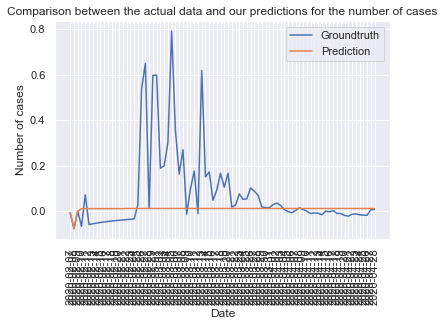

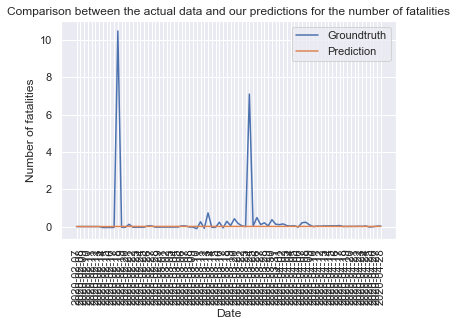

In [138]:
display_comparison("DEU", groundtruth_df)

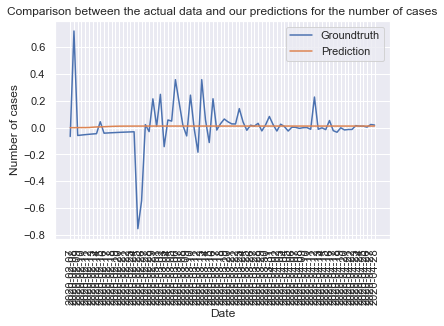

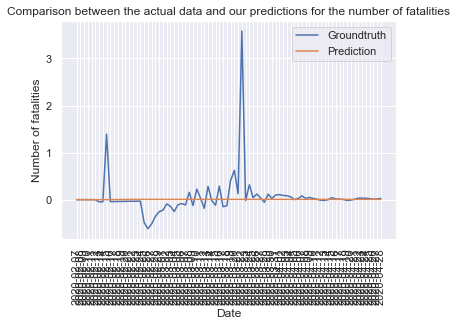

In [139]:
display_comparison("FRA", groundtruth_df)